# Bulk functional analysis

Bulk RNA-seq yields many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by inferring pathway and transcription factor activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for transcription factor (TF) and pathway activity inference from a human data-set. The data consists of 6 samples of hepatic stellate cells (HSC) where three of them were activated by the cytokine Transforming growth factor (TGF-β), it is available at GEO [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE151251).

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle RNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd
from anndata import AnnData

## Loading the data

We can download the data easily from GEO:

In [2]:
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz' -O counts.txt.gz
!gzip -d -f counts.txt.gz

--2025-02-05 20:55:55--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
connected. to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 1578642 (1,5M) [application/octet-stream]
Saving to: ‘counts.txt.gz’

counts.txt.gz       100%[===================>]   1,50M  1,77MB/s    in 0,9s    

2025-02-05 20:55:56 (1,77 MB/s) - ‘counts.txt.gz’ saved [1578642/1578642]



We can then read it using `pandas`:

In [3]:
# Read raw data and process it
adata = pd.read_csv('counts.txt', index_col=2, sep='\t').iloc[:, 5:].T
adata

GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


<div class="alert alert-info">

**Note**
    
In case your data does not contain gene symbols but rather gene ids like ENSMBL, you can use the function `sc.queries.biomart_annotations` to retrieve them.
In this other [vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html), ENSMBL ids are transformed into gene symbols.


</div>

<div class="alert alert-info">

**Note**
    
In case your data is not from human but rather a model organism, you can find their human orthologs using `pypath`.
Check this GitHub [issue](https://github.com/saezlab/decoupler-py/issues/5#issuecomment-1137099265) where mouse genes are transformed into human.


</div>

The obtained data consist of raw read counts for six different samples (three controls, three treatments) for ~60k genes.
Before continuing, we will transform our expression data into an `AnnData` object. It handles annotated data matrices
efficiently in memory and on disk and is used in the scverse framework. You can read more about it 
[here](https://scverse.org/) and [here](https://anndata.readthedocs.io/en/latest/).

In [4]:
# Transform to AnnData object
adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

/home/badi/miniforge3/envs/dcp/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/badi/miniforge3/envs/dcp/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/badi/miniforge3/envs/dcp/lib/python3.11/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


AnnData object with n_obs × n_vars = 6 × 64253

Inside an `AnnData` object, there is the `.obs` attribute where we can store the metadata of our samples.
Here we will infer the metadata by processing the sample ids, but this could also be added from a separate dataframe:

In [5]:
# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

# Visualize metadata
adata.obs

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32
33_HSCs-TGFb3,treatment,33


## Quality control

Before doing anything we need to ensure that our data passes some quality control thresholds. In transcriptomics it can happen
that some genes were not properly profiled and thus need to be removed.

To filter genes, we will follow the strategy implemented in the function `filterByExpr` from [edgeR](https://rdrr.io/bioc/edgeR/man/filterByExpr.html).
It keeps genes that have a minimum total number of reads across samples (`min_total_count`), and that have a minimum number of counts in a number of samples (`min_count`).

We can plot how many genes do we keep, you can play with the `min_count` and `min_total_count` to check how many genes would be kept when changed:

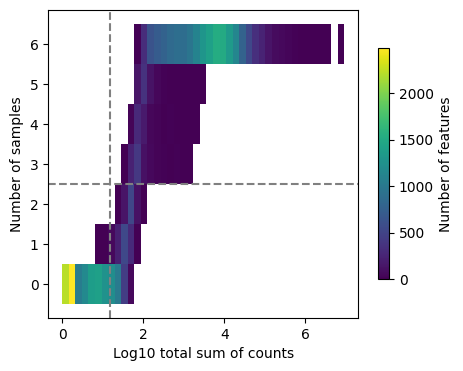

In [6]:
dc.plot_filter_by_expr(adata, group='condition', min_count=10, min_total_count=15, large_n=1, min_prop=1)

Here we can observe the frequency of genes with different total sum of counts and number of samples. The dashed lines indicate the current thresholds, meaning that only the genes in the upper-right corner are going to be kept. Filtering parameters is completely arbitrary, but a good rule of thumb is to identify bimodal distributions and split them modifying the available thresholds.
In this example, with the default values we would keep a good quantity of genes while filtering potential noisy genes.

<div class="alert alert-info">

**Note**
    
Changing the value of `min_count` will drastically change the distribution of "Number of samples", not change its threshold.
In case you want to lower or increase it, you need to play with the `group`, `large_n` and `min_prop` parameters. 


</div>

<div class="alert alert-info">

**Note**

This thresholds can vary a lot between datasets, manual assessment of them needs to be considered. For example, it might be
the case that many genes are not expressed in just one sample which they would get removed by the current setting. For this
specific dataset it is fine.

</div>

Once we are content with the threshold parameters, we can perform the actual filtering:

In [7]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group='condition', min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 6 × 19713
    obs: 'condition', 'sample_id'

## Differential expression analysis

In order to identify which are the genes that are changing the most between treatment and control we can perform differential
expression analysis (DEA). For this example, we will perform a simple experimental design where we compare the gene expression
of treated cells against controls. We will use the python implementation of the framework DESeq2, but we could have used any
other one (`limma` or `edgeR` for example). For a better understanding how it works, check
[DESeq2's documentation](https://pydeseq2.readthedocs.io/en/latest/). Note that more complex experimental designs can be used
by adding more factors to the `design_factors` argument.

In [8]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [9]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=adata,
    design_factors='condition',
    refit_cooks=True,
    inference=inference,
)

In [10]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 5.47 seconds.

Fitting dispersion trend curve...
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 5.77 seconds.

Fitting LFCs...
... done in 2.95 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [11]:
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(
    dds,
    contrast=["condition", 'treatment', 'control'],
    inference=inference
)

In [12]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition treatment vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneName                                                                   
WASH7P           10.349784       -0.011131  0.651869 -0.017076  0.986376   
MIR6859-1        10.114621        0.000629  0.657529  0.000956  0.999237   
RP11-34P13.7     45.731312        0.078209  0.324481  0.241027  0.809534   
RP11-34P13.8     29.498379       -0.065180  0.393676 -0.165567  0.868498   
CICP27          106.032659        0.150597  0.222996  0.675332  0.499465   
...                    ...             ...       ...       ...       ...   
MT-ND6        17914.984474       -0.435304  0.278796 -1.561372  0.118436   
MT-TE          1281.293477       -0.332495  0.288073 -1.154204  0.248416   
MT-CYB        54955.449372       -0.313285  0.286900 -1.091966  0.274848   
MT-TT           204.692221       -0.485883  0.220577 -2.202783  0.027610   
MT-TP           345

... done in 1.30 seconds.



In [13]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
WASH7P,10.349784,-0.011131,0.651869,-0.017076,0.986376,0.991406
MIR6859-1,10.114621,0.000629,0.657529,0.000956,0.999237,0.999517
RP11-34P13.7,45.731312,0.078209,0.324481,0.241027,0.809534,0.877358
RP11-34P13.8,29.498379,-0.065180,0.393676,-0.165567,0.868498,0.917099
CICP27,106.032659,0.150597,0.222996,0.675332,0.499465,0.637279
...,...,...,...,...,...,...
MT-ND6,17914.984474,-0.435304,0.278796,-1.561372,0.118436,0.210888
MT-TE,1281.293477,-0.332495,0.288073,-1.154204,0.248416,0.379998
MT-CYB,54955.449372,-0.313285,0.286900,-1.091966,0.274848,0.411223


We can plot the obtained results in a volcano plot:

/home/badi/miniforge3/envs/dcp/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


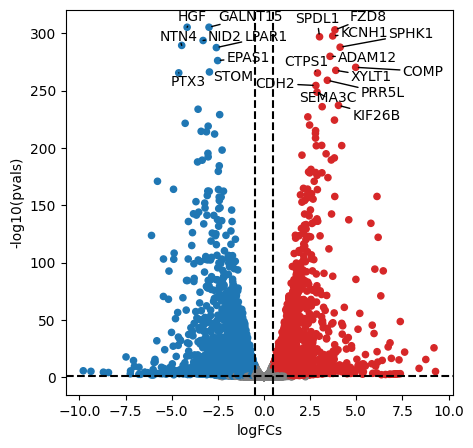

In [14]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(5, 5)
)

After performing DEA, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used,
but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value.
We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by `decoupler`:

In [15]:
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

GeneName,WASH7P,MIR6859-1,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
treatment.vs.control,-0.017076,0.000956,0.241027,-0.165567,0.675332,-1.645555,2.041528,-0.376872,-1.994784,-0.498507,...,-1.435973,0.755042,1.139185,1.167225,-1.242576,-1.561372,-1.154204,-1.091966,-2.202783,-2.849413


## Transcription factor activity inference

The first functional analysis we can perform is to infer transcription factor (TF) activities from our transcriptomics data. We will need a gene regulatory network (GRN) and a statistical method.

### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource
containing a curated collection of TFs and their transcriptional targets
compiled from 12 different resources. This collection provides an increased
coverage of transcription factors and a superior performance in identifying
perturbed TFs compared to our previous
[DoRothEA](https://saezlab.github.io/dorothea/) network and other literature
based GRNs. Similar to DoRothEA, interactions are weighted by their mode of
regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also
available). We can use `decoupler` to retrieve it from `omnipath`. The argument
`split_complexes` keeps complexes or splits them into subunits, by default we
recommend to keep complexes together.

<div class="alert alert-info">

**Note**

In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 

</div> 

In [16]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight
0,ABL1,BAX,1
1,ABL1,BCL2,-1
2,ABL1,BCL6,-1
3,ABL1,CCND2,1
4,ABL1,CDKN1A,1
...,...,...,...
40625,ZXDC,CDKN1C,1
40626,ZXDC,CDKN2A,1
40627,ZXDC,CIITA,1
40628,ZXDC,HLA-E,1


### Activity inference with Univariate Linear Model (ULM)

To infer TF enrichment scores we will run the Univariate Linear Model (`ulm`) method. For each sample in our dataset (`mat`) and each TF in our network (`net`), it fits a linear model that predicts the observed gene expression
based solely on the TF's TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

<img src="../ulm.png" />

We can run `ulm` with a one-liner:

In [17]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 19713 targets for 631 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
treatment.vs.control,-2.182166,-1.463531,-2.081165,-1.273933,-2.674602,0.273812,-3.937424,0.871381,1.650731,-0.792727,...,-0.062734,2.123533,1.888819,-1.140941,-1.57182,-1.277257,-0.116779,3.375851,0.9178,-2.745395


Let us plot the obtained scores for the top active/inactive transcription factors:

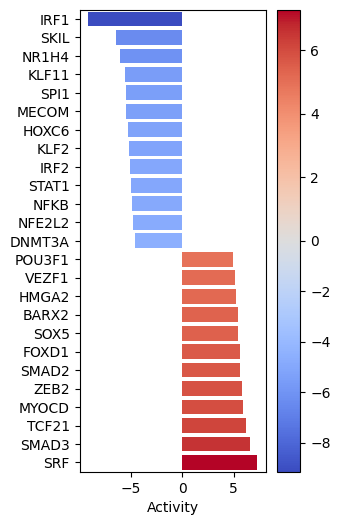

In [18]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='treatment.vs.control',
    top=25,
    vertical=True,
    figsize=(3, 6)
)

MYOCD SRF and JUNB seem to be the most activated in this treatment while IRF1, KLF11 AND ARID1A seem to be inactivated.

We can also plot the network of interesting TFs (top and bottom by activity) and color the nodes by activity and target gene expression:

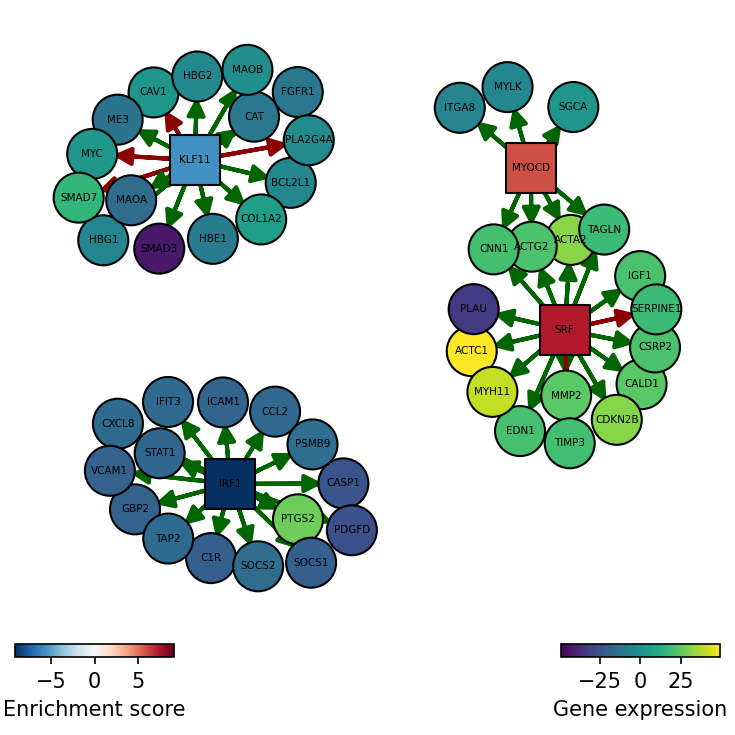

In [19]:
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=['MYOCD', 'SRF', 'IRF1', 'KLF11'],
    n_targets=15,
    node_size=50,
    figsize=(5, 5),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True
)

SRF seems to be active in treated cells since their positive targets are up-regulated.

If needed, we can also look at a volcano plot of the target genes:

/home/badi/miniforge3/envs/dcp/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


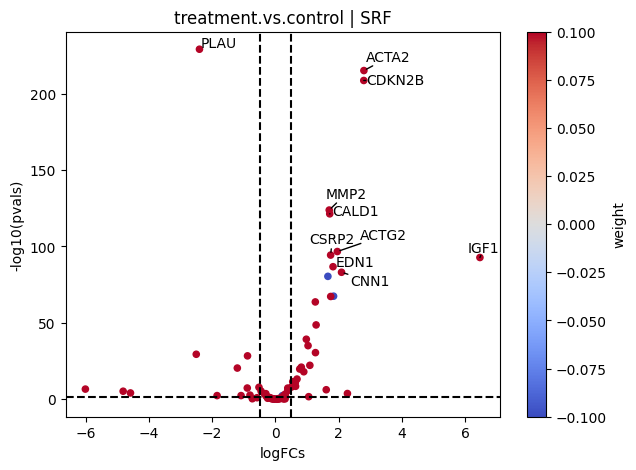

In [20]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'treatment.vs.control'})
pvals = results_df[['padj']].T.rename(index={'padj': 'treatment.vs.control'})

# Plot
dc.plot_volcano(
    logFCs,
    pvals,
    'treatment.vs.control',
    name='SRF',
    net=collectri,
    top=10,
    sign_thr=0.05,
    lFCs_thr=0.5
)

## Pathway activity inference

Another analysis we can perform is to infer pathway activities from our transcriptomics data.

### PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs.
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs.
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.
- **MAPK**: integrates external signals and promotes cell growth and proliferation.
- **NFkB**: regulates immune response, cytokine production and cell survival.
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- **PI3K**: promotes growth and proliferation.
- **TGFb**: involved in development, homeostasis, and repair of most tissues.
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- **Trail**: induces apoptosis.
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.
- **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

In [21]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.0
1,Androgen,NKX3-1,10.622551,0.0
2,Androgen,MBOAT2,10.472733,0.0
3,Androgen,KLK2,10.176186,0.0
4,Androgen,SARG,11.386852,0.0
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,0.000002
6996,p53,CFDP1,-1.628168,0.000002
6997,p53,VPS37D,2.309503,0.000002
6998,p53,TEDC1,-2.274823,0.000002


### Activity inference with Multivariate Linear Model (MLM)

To infer pathway enrichment scores we will run the Multivariate Linear Model (`mlm`) method. For each sample in our dataset (`adata`), it fits a linear model that predicts the observed gene expression based on all pathways' Pathway-Gene interactions weights.
Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

<img src="../mlm.png" />
     
We can run `mlm` with a one-liner:

In [22]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
pathway_acts

Running mlm on mat with 1 samples and 19713 targets for 14 sources.


,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
treatment.vs.control,1.443525,-1.31858,1.547516,8.053596,-13.001565,8.005248,1.43121,7.49645,45.562359,-6.975317,-1.449814,3.470261,-0.448719,-5.730709


Let us plot the obtained scores:

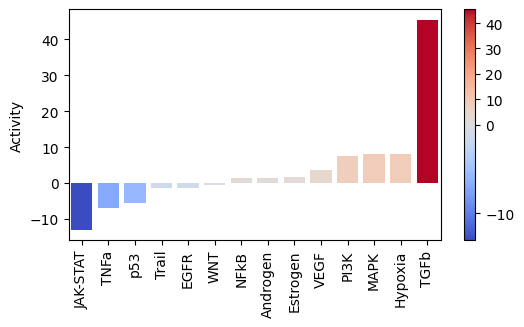

In [23]:
dc.plot_barplot(
    pathway_acts,
    'treatment.vs.control',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

As expected, after treating cells with the cytokine TGFb we see an increase of activity for this pathway.

On the other hand, it seems that this treatment has decreased the activity of other pathways like JAK-STAT or TNFa.

We can visualize the targets of TFGb in a scatter plot:

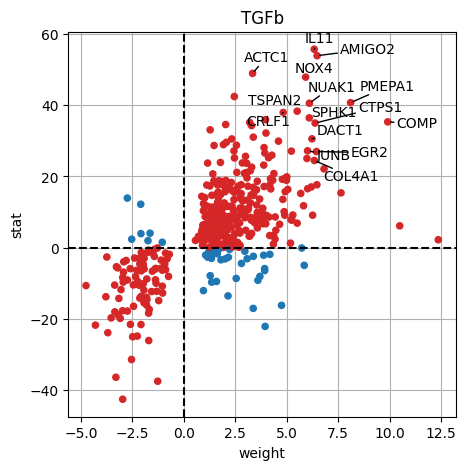

In [24]:
dc.plot_targets(results_df, stat='stat', source_name='TGFb', net=progeny, top=15)

The observed activation of TGFb is due to the fact that majority of its target genes with positive weights have positive
t-values (1st quadrant), and the majority of the ones with negative weights have negative t-values (3d quadrant).

## Functional enrichment of biological terms

Finally, we can also infer activities for general biological terms or processes.

### MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [25]:
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
,,,
0,A1BG,immunesigdb,GSE25088_CTRL_VS_IL4_AND_ROSIGLITAZONE_STIM_MA...
1,A1BG,tf_targets_legacy,TGTTTGY_HNF3_Q6
2,A1BG,positional,chr19q13
3,A1BG,cell_type_signatures,GAO_LARGE_INTESTINE_ADULT_CI_MESENCHYMAL_CELLS
4,A1BG,go_cellular_component,GOCC_EXTERNAL_ENCAPSULATING_STRUCTURE
...,...,...,...
5522261,ZZZ3,go_biological_process,GOBP_MACROMOLECULE_DEACYLATION
5522262,ZZZ3,go_biological_process,GOBP_CELL_CYCLE
5522263,ZZZ3,tf_targets_gtrf,ZNF507_TARGET_GENES


As an example, we will use the hallmark gene sets, but we could have used any other. 

<div class="alert alert-info">

**Note**
    
To see what other collections are available in MSigDB, type: `msigdb['collection'].unique()`.

</div>  

We can filter by for `hallmark`:

In [26]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

msigdb

,genesymbol,collection,geneset
,,,
455,A2M,hallmark,COAGULATION
557,A2M,hallmark,IL6_JAK_STAT3_SIGNALING
917,AAAS,hallmark,DNA_REPAIR
1471,AADAT,hallmark,FATTY_ACID_METABOLISM
2932,AARS1,hallmark,ALLOGRAFT_REJECTION
...,...,...,...
5516433,ZPBP,hallmark,SPERMATOGENESIS
5520316,ZW10,hallmark,E2F_TARGETS
5520404,ZW10,hallmark,PROTEIN_SECRETION


### Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.run_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.

<img src="../ora.png" />
     
We can run `ora` with a simple one-liner:

In [27]:
# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['padj'] < 0.01]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

enr_pvals.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,277,0.350181,0.464151,1.0,1.015590,7.795104e-01,ABCA1;ACADM;ACADS;ACLY;ACOX1;ADCY6;ADIPOR2;AGP...
1,ALLOGRAFT_REJECTION,358,0.184358,1.000000,1.0,0.531561,1.537109e-12,ABCE1;ABI1;APBB1;B2M;BCAT1;BCL3;CCL2;CCND3;CD4...
2,ANDROGEN_RESPONSE,148,0.358108,0.408147,1.0,1.041463,9.332836e-01,ABCC4;ACTN1;ADAMTS1;ALDH1A3;ANKH;ARID5B;B2M;B4...
3,ANGIOGENESIS,55,0.345455,0.554044,1.0,1.015414,5.996130e-01,COL3A1;CXCL6;FGFR1;FSTL1;ITGAV;JAG1;LUM;NRP1;O...
4,APICAL_JUNCTION,309,0.307443,0.933759,1.0,0.890199,6.101120e-02,ACTA1;ACTB;ACTC1;ACTG1;ACTG2;ACTN1;ACTN4;ADAM1...


Then we can visualize the most enriched terms:

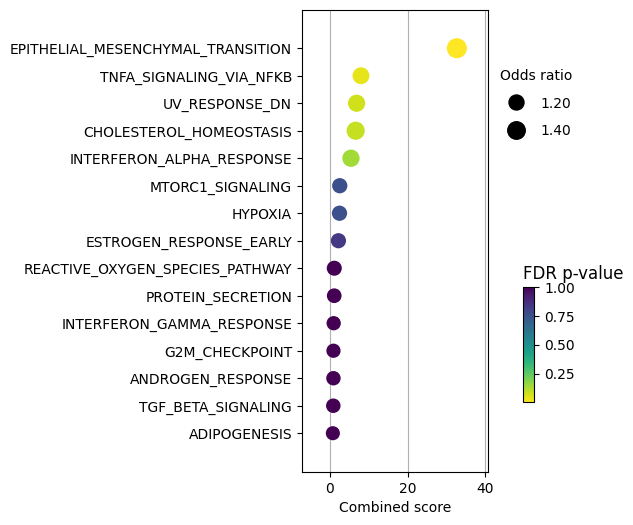

In [28]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=1.5,
    figsize=(3, 6)
)

TNFa and interferons response (JAK-STAT) processes seem to be enriched. We previously observed a similar result with the PROGENy pathways, were they were significantly downregulated. Therefore, one of the limitations of using a prior knowledge resource without weights is that it doesn't provide direction.

We can also plot the running score for a given gene set:

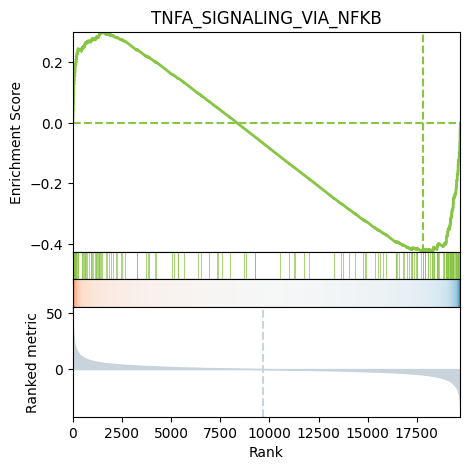

In [29]:
# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='TNFA_SIGNALING_VIA_NFKB'
)

## Enrichment of ligand-receptor interactions

Recently, study of interactions between ligands and receptors have gained significant traction, notably pushed by the democratization of single cell sequencing technologies. While most methods (such as the one described in LIANA) are developed for single cell datasets, they rely on a relatively simple assumption of co-expression or co-regulation of two (or more in the context of complexes) genes acting as ligand and receptors to propose hypothetical ligand-receptor interaction events. This concept can seamlessly be applied to a bulk RNA dataset, where the assumption is that sender and receiver cells are convoluted in a single dataset, but the observation of significant co-regulation of ligand and receptors should still correspond to hypothetical ligand-receptor interaction events.

At the core, most current ligand-receptor interaction methods rely on averaging the measurements obtained for ligand and receptor and standardizing them against a background distribution.  Thus, an enrichment method based on a weighted mean can emulate this, where the sets are simply the members of a ligand receptor pair (or more in the context of complexes).

Thus, we can extract ligand-receptor interaction ressources from the LIANA package (available both in [R](https://saezlab.github.io/liana/) and [python](https://liana-py.readthedocs.io/en/latest/)), and use it as a prior knowledge network with decoupler to find the most significant pairs of ligand-receptors in a given bulk dataset.

While more work is required to fully understand the functional relevance of the highlighted ligand-receptor interactions with such an approach, this represents a very straightforward and intuitive approach to embed a bulk RNA dataset with ligand-receptor interaction prior knowledge.


First, we extract ligand-receptor interactions from liana, and decomplexify them to format them into an appropriate decoupleR input.

In [30]:
import liana as ln

liana_lr = ln.resource.select_resource()
liana_lr = ln.resource.explode_complexes(liana_lr)

# Create two new DataFrames, each containing one of the pairs of columns to be concatenated
df1 = liana_lr[['interaction', 'ligand']]
df2 = liana_lr[['interaction', 'receptor']]

# Rename the columns in each new DataFrame
df1.columns = ['interaction', 'genes']
df2.columns = ['interaction', 'genes']

# Concatenate the two new DataFrames
liana_lr = pd.concat([df1, df2], axis=0)
liana_lr['weight'] = 1

# Find duplicated rows
duplicates = liana_lr.duplicated()

# Remove duplicated rows
liana_lr = liana_lr[~duplicates]

liana_lr

,interaction,genes,weight
0,LGALS9&PTPRC,LGALS9,1
1,LGALS9&MET,LGALS9,1
2,LGALS9&CD44,LGALS9,1
3,LGALS9&LRP1,LGALS9,1
4,LGALS9&CD47,LGALS9,1
...,...,...,...
5775,BMP2&ACTR2,ACTR2,1
5776,BMP15&ACTR2,ACTR2,1
5777,CSF1&CSF3R,CSF3R,1
5778,IL36G&IFNAR1,IFNAR1,1


Then we can use `ulm` to find the significant co-regulated pairs of ligand and receptors.

In [31]:
# Infer lr activities with ulm
lr_score, lr_pvalue = dc.run_ulm(
    mat=mat,
    net=liana_lr,
    source='interaction',
    target='genes',
    min_n=2,
    verbose=True
)

Running ulm on mat with 1 samples and 19713 targets for 2112 sources.


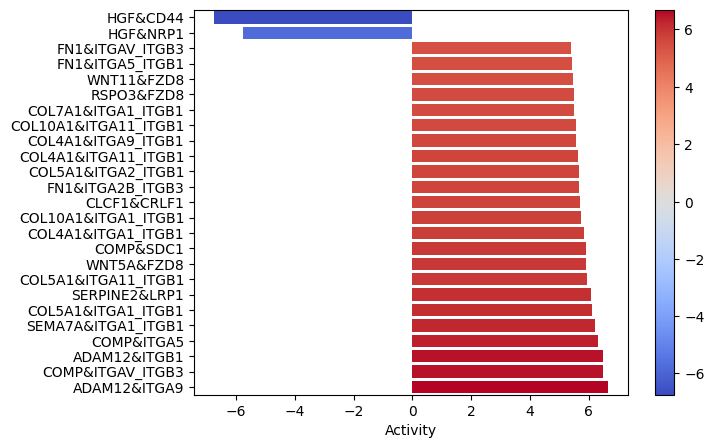

In [32]:
dc.plot_barplot(lr_score, 'treatment.vs.control', top=25, vertical=True)

Interactions between colagens and the ITG_ITG complexes seems to be quite enrichned. That is especially relevant since the EMT pathway was significantly enriched in the functional pathway analysis.